### Author: Jay Parmar
### 1. Introduction
    1.1 Information about the result and dataset
    1.2 Important libraries used in the program

### 2. Data preparation
    2.1 Load data and Reshape
    2.2 Data visualization and Labeling
    2.3 Normalization and Split training and valdiation set

### 3. CNN and Optimization
    3.1 Define the generalized model
    3.2 Define hyperparameters to be optimized
    3.3 Create objective function to be maximized
    3.4 Data augmentation
    3.5 Define an algorithm to perform a number of trials
    3.6 Performance Visualization

### 4. Evaluation
    4.1 Recreate the optimized CNN model with best hyperparameters
    4.2 Training and validation curves
    4.3 Confusion matrix
    4.4 Error investigation

# 1. Introduction

This is a multi-layer Sequential Convolutional Neural Network (CNN) for image recognition, which is trained on CIFAR10 dataset. Keras API (Tensorflow backend) is chosen to be used, which is very intuitive. 

76.1% of accuracy is achieved with the optimized CNN out of 100 differently configured CNN trials performed. It took 17 hours to run the code on P&G Makerspace PC, which is supported with NVIDIA Graphics card RTX 1080. Due to the graphic card, the computation became much faster.

The block below is to import some important libraries to run this programs. 

Here is the list of the libraries.
1. os - to execute a shell command and to get the users environment
2. random - to generate random numbers
3. tensorflow - it has a comprehensive, flexible ecosystem of tools, libraries and community resources that lets researchers push the state-of-the-art in ML and developers easily build and deploy ML powered applications
4. matplotlib - a comprehensive library for creating static, animated and interactive visualizations in Python
5. keras - a Python library for deep learning that can run on top of Theano or TensorFlow (Very popular for deep learning)
6. csv - CSV file reading and writing
7. pickle - for serializing and de-serializing a Python object structure
8. sklearn - to provide a nice and easy to use methods for feature selection
9. pandas - to import and then inspect a variety of datasets
10. seaborn - a Python data visualization library based on matplotlib

In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(0)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import random
random.seed(0)
import numpy as np
np.random.seed(0)
import tensorflow as tf
tf.compat.v1.set_random_seed(0)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
from keras.optimizers import adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.applications import ResNet50
from keras.utils import to_categorical
import csv
import pickle
cifar_image_path = 'cifar-10-batches-py'
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


Optuna: An automatic hyperparameter optimization software framework, particularly designed for machine learning. It features an imperative, define-by-run style user API.

In [ ]:
import optuna
from optuna.integration import KerasPruningCallback
tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.experimental.list_logical_devices('GPU')))

Num GPUs Available:  1


## 2. Data Preparation

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes.

### 2.1 Load data and Reshape

'load_cifar10_data' and 'load_cifar10_test_data' are two functions to load cifar10 images stored in 'cifar_image_path'. The training images are stored batchwise in different 5 batches in the folder. 

1. 'load_cifar10_data' function returns two matrices for training purpose: 
    1. feature matrix of size 50,000 (contains images of 32x32x3 pixels) and 
    2. labels matrix of size 50,000, which contains true labels of the images from feature matrix in the same order.


2. 'load_cifar10_test_data' function returns two matrices for testing purpose: 
    1. feature matrix of size 10,000 (contains images of 32x32x3 pixels) and 
    2. labels matrix of size 50,000, which contains true labels of the images from feature matrix in the same order.

In [ ]:
#function to load cifar-10 image-file (batch wise)
def load_cifar10_data(cifar_image_path, n_batch):
    
    features = []
    labels = []
    
    for batch_id in range(1, n_batch + 1):
        #'with open()'- opens the file 
        #f = open("path_to_file", mode='r+b') in reading + binary mode
        with open(cifar_image_path + '/data_batch_' + str(batch_id), mode='r+b') as file:
    
            #Module translates an in-memory Python object  
            #into a serialized byte stream—a string of  
            #bytes that can be written to any file-like object.
            #pickle.load - with filename
            #pickle.loads - without filename
            batch = pickle.load(file, encoding='latin1')
         
        for i in range(0, len(batch['labels'])):
        
            features.append(batch['data'][i])
            labels.append(batch['labels'][i])
    
    #divide the row vector (3072) into 3 pieces. Each piece corresponds to the each channels.
    #this results in (3 x 1024) dimension of tensor.
    #divide the resulting tensor from the previous step with 32. 32 here means width of an image.
    #this results in (3 x 32 x 32)    
    features = np.array(features)
    labels = np.array(labels)
    features = features.reshape((len(features), 3, 32, 32)).transpose(0, 2, 3, 1)
    
    return features, labels


#function to load cifar-10 test image-file
def load_cifar10_test_data(cifar_image_path):
    
    features = []
    labels = []
    
    with open(cifar_image_path + '/test_batch', mode='r+b') as file:
        
        batch = pickle.load(file, encoding='latin1')
     
    for i in range(0, len(batch['labels'])):
        
        features.append(batch['data'][i])
        labels.append(batch['labels'][i])
       
    features = np.array(features)
    labels = np.array(labels)
    features = features.reshape((len(features), 3, 32, 32)).transpose(0, 2, 3, 1)
    
    return features, labels
    

### 2.2 Dataset Visualisation and Labeling

The CIFAR10 dataset has 10 classes which are mentioned below: 

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 

These classes are numbered from 0 to 9 in the mentioned order.

The block below would help to visualize CIFAR10 images.

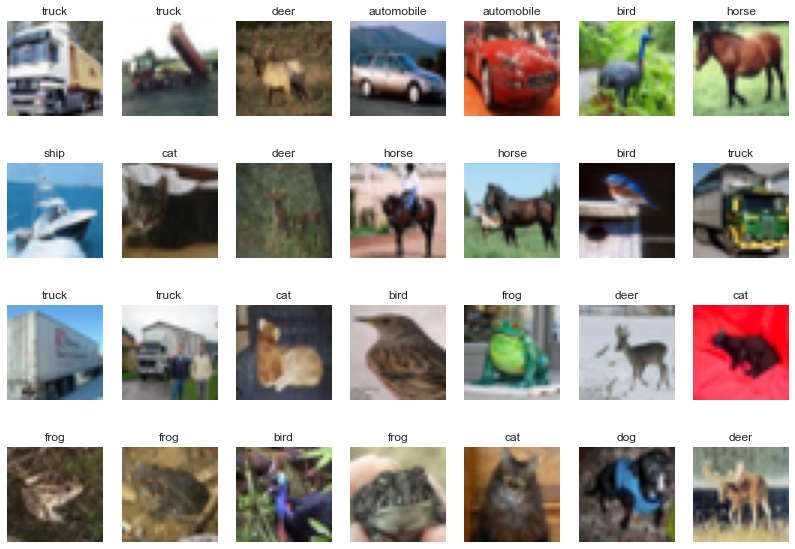

In [ ]:
features, labels = load_cifar10_data(cifar_image_path, 5)

fig = plt.figure(figsize=(14,10))

def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 

names = load_label_names()

for n in range(1, 29):
    fig.add_subplot(4, 7, n)
    img = features[n]
    plt.imshow(img)
    plt.title(names[labels[n]])
    plt.axis('off')
    
del features
del labels

### 2.3 Normalization and Split training and valdiation set

The dataset consisted of 60,000 images is split into two parts. 
    1. training dataset 2. validataion dataset
   
Validation dataset is 10% of training dataset.

In [ ]:
training_images, training_labels = load_cifar10_data(cifar_image_path, 5)
training_images = training_images/255.0
    
test_images, test_labels = load_cifar10_test_data(cifar_image_path)
test_images = test_images/255.0

training_images, X_val, training_labels, Y_val = train_test_split(training_images, 
                                                                  training_labels, 
                                                                  test_size = 0.1, 
                                                                  random_state= 0)

## 3. CNN and Optimization

### 3.1 Define the generalized model

The Keras Sequential API is used, where you just have to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. For the first convolutional layer, I have chosen to set it either 32 or 64  filters of size (3x3). Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

Here, number of convolutional layers to be added in the NN is also a variable. It ranges from 1 to 4 with different number of filters.

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. 

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end, I used the features in fully-connected (Dense) layers. The number of fully-connected layers are not fixed. It varies according to the requirement of the dataset to achieve higher accuracy. Also, I have added dropout layers with different rates to disable some portion of neurons while training in order to avoid coadaption among neurons.

In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

While building the network, learning rate is not fixed but varied between 0.01 to 0.00001 to dervie the optimized value.

### 3.2 Define hyperparameters to be optimized

List of hyperparameters incorporated in the model:

1. Number of filters in the 1st Convolution layer
2. Number of Covolution layers after the 1st convolutional layer + number of filters in each layer
3. Number of Dense layers  + Number of hidden units inside each dense layer
4. Dropout rate for each Dense layer
5. Learning rate
6. Batch size


In [ ]:
def create_model(trial):
    
    model = Sequential()
    num_filters = trial.suggest_uniform("n_filters", 0.4, 0.7)
    num_filters = int(num_filters*64)
    model.add(
        Conv2D(
            filters=num_filters,
            kernel_size= (3,3),
            padding = 'same',
            activation= 'relu',
            input_shape=(32,32,3),
            )
        )  
    n_cnn = trial.suggest_int("n_cnn", 1, 3)
    if n_cnn > 0:
        num_filters1 = trial.suggest_uniform("n_filters_1", 0.7, 1.0)
        num_filters1 = int(num_filters1*70)
        model.add(
            Conv2D(
            filters=num_filters1,
            kernel_size= (3,3),
            padding = 'same',
            activation= 'relu'
            )
        )
        if n_cnn > 1:
            model.add(MaxPooling2D(pool_size=(2,2)))
            num_filters2 = trial.suggest_uniform("n_filters_2", 0.8, 1.0)
            num_filters2 = int(num_filters2*80)
            model.add(
                Conv2D(
                filters=num_filters2,
                kernel_size= (3,3),
                padding = 'same',
                activation= 'relu'
                )
            )
            if n_cnn > 2:
                num_filters3 = trial.suggest_uniform("n_filters_3", 0.8, 1.0)
                num_filters3 = int(num_filters3*80)
                model.add(
                    Conv2D(
                    filters=num_filters3,
                    kernel_size= (3,3),
                    padding = 'same',
                    activation= 'relu'
                    )
                )    
                    
    model.add(MaxPooling2D(pool_size=(2,2)))   
    model.add(Flatten())
    
    n_layers = trial.suggest_int("n_layers", 1, 3)
    
    if n_layers > 0:
        num_hidden1 = trial.suggest_uniform("n_units_1", 0.1, 1.0)
        num_hidden1 = int(num_hidden1*1500)
        model.add(Dense(num_hidden1, activation="relu"))
        dropout1 = trial.suggest_uniform("dropout_1", 0.1, 0.45)
        model.add(Dropout(rate=dropout1))
        if n_layers > 1:
            num_hidden2 = trial.suggest_uniform("n_units_2", 0.1, 1.0)
            num_hidden2 = int(num_hidden2*1200)
            model.add(Dense(num_hidden2, activation="relu"))
            dropout2 = trial.suggest_uniform("dropout_2", 0.2, 0.45)
            model.add(Dropout(rate=dropout2))
            if n_layers > 2:
                num_hidden3 = trial.suggest_uniform("n_units_3", 0.1, 1.0)
                num_hidden3 = int(num_hidden3*900)
                model.add(Dense(num_hidden3, activation="relu"))
                dropout3 = trial.suggest_uniform("dropout_3", 0.3, 0.45)
                model.add(Dropout(rate=dropout3))
    
    model.add(Dense(10, activation="softmax"))

    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)    
    
    opt = SGD(lr = lr)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

### 3.3 Create objective function to be maximized

Optuna is a black-box optimizer, which means it needs an objective function, which returns a numerical value to evaluate the performance of the hyperparameters, and decide where to sample in upcoming trials.

In this case, the objective function looks like this. 

Notice that the objective function is passed an Optuna specific argument of trial. This object is passed to the objective function to specify which hyperparameters should be tuned. This returns the accuracy of the model, which is used by Optuna as feedback on the performance of the trial.

### 3.4 Data augmentation

In order to avoid overfitting problem, we need to expand artificially our dataset. We can make the existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the image is not centered, the scale is not the same (some images are big and some are small), the image is rotated etc.

The approach that alter the training data such a way that it changes the array representation (32x32x3) of images, while keeping the label same, is known as data augmentation. 

Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. 

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [ ]:
def objective(trial):
    
    # clear clutter from previous session graphs.
    tf.keras.backend.clear_session()

    # Generate our trial model
    model = create_model(trial)
    
    batch_size = trial.suggest_int("Batch_size", 32, 256)
    
    datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1, # Randomly zoom image 
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images

    datagen.fit(training_images)  

    history = model.fit_generator(datagen.flow(training_images, training_labels, batch_size = batch_size),
                              epochs = 50, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch= training_images.shape[0] // batch_size,
                              callbacks=[KerasPruningCallback(trial, "val_accuracy")])
    
    # Evaluate the model accuracy on the test set
    score = model.evaluate(test_images, test_labels, verbose=0)
    print ('Test loss: {}, Test accuracy: {}'.format(score[0], score[1]*100.0)) 
    return score[1]

### 3.5 Define an algorithm to perform a number of trials

The default algorithm in Optuna to make a smart guess for the net hyperparameter values and perform the next trials is Tree-structured Parzen Estimater (TPE), which is a form of Bayesian Optimization. Optuna uses TPE to search more efficiently than a random search, by choosing points closer to previous good results. Apart from TPE, in this code, I have used one more algorithm called CMA-ES. According to studies, it provides better result if mixture of TPE and CMA-ES is used.

In this study, first 50 trials are performed using TPE and then rest of the 50 trials are performed using CMA-ES. Total 100 trials are performend.

In [ ]:
n = 100
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(sampler = sampler, direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=n/2)
sampler = optuna.integration.CmaEsSampler(seed = 0)
study.optimize(objective, n_trials=n/2)
pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 35)        980       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 56)        17696     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 56)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14336)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 811)               11627307  
_________________________________________________________________
dropout_1 (Dropout)          (None, 811)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 17:26:56,488] Finished trial#0 resulted in value: 0.46720001101493835. Current best value is 0.46720001101493835 with parameters: {'n_filters': 0.5509339058265585, 'n_cnn': 1, 'n_filters_1': 0.8090359444097356, 'n_layers': 1, 'n_units_1': 0.5411105158351104, 'dropout_1': 0.24186244149542163, 'lr': 0.001093612914913914, 'Batch_size': 178}.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 29)        812       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 62)        16244     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 62)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15872)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1202)              19079346  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1202)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 347)              

[I 2020-06-04 17:42:30,731] Finished trial#1 resulted in value: 0.6172000169754028. Current best value is 0.6172000169754028 with parameters: {'n_filters': 0.4605588135569391, 'n_cnn': 1, 'n_filters_1': 0.8880463342040821, 'n_layers': 2, 'n_units_1': 0.8015992502427585, 'dropout_1': 0.2073831488358051, 'n_units_2': 0.2894673427732203, 'dropout_2': 0.4429202526405841, 'lr': 0.009092167299169746, 'Batch_size': 231}.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 38)        1064      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 50)        17150     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 50)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 172)               2201772   
_________________________________________________________________
dropout_1 (Dropout)          (None, 172)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 384)              

[I 2020-06-04 17:59:36,403] Finished trial#2 resulted in value: 0.17970000207424164. Current best value is 0.6172000169754028 with parameters: {'n_filters': 0.4605588135569391, 'n_cnn': 1, 'n_filters_1': 0.8880463342040821, 'n_layers': 2, 'n_units_1': 0.8015992502427585, 'dropout_1': 0.2073831488358051, 'n_units_2': 0.2894673427732203, 'dropout_2': 0.4429202526405841, 'lr': 0.009092167299169746, 'Batch_size': 231}.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 34)        952       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        19648     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 66)        38082     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 66)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4224)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 296)              

[I 2020-06-04 18:15:36,784] Finished trial#3 resulted in value: 0.27469998598098755. Current best value is 0.6172000169754028 with parameters: {'n_filters': 0.4605588135569391, 'n_cnn': 1, 'n_filters_1': 0.8880463342040821, 'n_layers': 2, 'n_units_1': 0.8015992502427585, 'dropout_1': 0.2073831488358051, 'n_units_2': 0.2894673427732203, 'dropout_2': 0.4429202526405841, 'lr': 0.009092167299169746, 'Batch_size': 231}.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 29)        812       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 55)        14410     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 55)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14080)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 203)               2858443   
_________________________________________________________________
dropout_1 (Dropout)          (None, 203)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 231)              

[I 2020-06-04 18:35:45,102] Finished trial#4 resulted in value: 0.6794000267982483. Current best value is 0.6794000267982483 with parameters: {'n_filters': 0.46159352602618675, 'n_cnn': 1, 'n_filters_1': 0.7858833110619374, 'n_layers': 2, 'n_units_1': 0.1355554490427764, 'dropout_1': 0.4362636227446546, 'n_units_2': 0.19252430943118382, 'dropout_2': 0.3433431560405651, 'lr': 0.003509745518411875, 'Batch_size': 32}.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 35)        980       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 62)        19592     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 62)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 71)        39689     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 71)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4544)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1114)             

[I 2020-06-04 18:36:28,726] Setting status of trial#5 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 31)        868       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 68)        19040     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 68)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 71)        43523     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 71)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4544)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 511)              

[I 2020-06-04 18:37:09,082] Setting status of trial#6 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 36)        1008      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        20800     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 66)        38082     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 73)        43435     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 73)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4672)             

[I 2020-06-04 18:37:53,072] Setting status of trial#7 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 33)        924       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 62)        18476     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 62)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 73)        40807     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 74)        48692     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 74)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4736)             

[I 2020-06-04 18:38:35,616] Setting status of trial#8 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 27)        756       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 49)        11956     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 49)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 76)        33592     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 76)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4864)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 990)              

[I 2020-06-04 18:39:17,697] Setting status of trial#9 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 41)        1148      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 55)        20350     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 55)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14080)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 528)               7434768   
_________________________________________________________________
dropout_1 (Dropout)          (None, 528)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 19:01:00,566] Finished trial#10 resulted in value: 0.7372000217437744. Current best value is 0.7372000217437744 with parameters: {'n_filters': 0.6491074653605682, 'n_cnn': 1, 'n_filters_1': 0.7866509544676187, 'n_layers': 1, 'n_units_1': 0.3522098175028743, 'dropout_1': 0.427366782278858, 'lr': 0.008397693337085085, 'Batch_size': 34}.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 41)        1148      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 55)        20350     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 55)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14080)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 495)               6970095   
_________________________________________________________________
dropout_1 (Dropout)          (None, 495)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 19:22:18,799] Finished trial#11 resulted in value: 0.7580000162124634. Current best value is 0.7580000162124634 with parameters: {'n_filters': 0.6498633989772796, 'n_cnn': 1, 'n_filters_1': 0.7905987298426417, 'n_layers': 1, 'n_units_1': 0.3305187495023552, 'dropout_1': 0.4445860301488324, 'lr': 0.009428316425838228, 'Batch_size': 35}.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 44)        1232      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 53)        21041     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 53)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13568)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 613)               8317797   
_________________________________________________________________
dropout_1 (Dropout)          (None, 613)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 19:45:25,158] Finished trial#12 resulted in value: 0.756600022315979. Current best value is 0.7580000162124634 with parameters: {'n_filters': 0.6498633989772796, 'n_cnn': 1, 'n_filters_1': 0.7905987298426417, 'n_layers': 1, 'n_units_1': 0.3305187495023552, 'dropout_1': 0.4445860301488324, 'lr': 0.009428316425838228, 'Batch_size': 35}.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 44)        1232      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 51)        20247     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 51)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13056)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 629)               8212853   
_________________________________________________________________
dropout_1 (Dropout)          (None, 629)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 20:03:07,194] Finished trial#13 resulted in value: 0.6467000246047974. Current best value is 0.7580000162124634 with parameters: {'n_filters': 0.6498633989772796, 'n_cnn': 1, 'n_filters_1': 0.7905987298426417, 'n_layers': 1, 'n_units_1': 0.3305187495023552, 'dropout_1': 0.4445860301488324, 'lr': 0.009428316425838228, 'Batch_size': 35}.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 43)        1204      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 57)        22116     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 57)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14592)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 764)               11149052  
_________________________________________________________________
dropout_1 (Dropout)          (None, 764)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 20:03:58,795] Setting status of trial#14 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 41)        1148      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 53)        19610     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 53)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 73)        34894     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 73)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4672)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 308)              

[I 2020-06-04 20:04:40,563] Setting status of trial#15 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 41)        1148      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 59)        21830     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 59)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15104)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 469)               7084245   
_________________________________________________________________
dropout_1 (Dropout)          (None, 469)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 20:05:25,035] Setting status of trial#16 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 39)        1092      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 52)        18304     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 52)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13312)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 668)               8893084   
_________________________________________________________________
dropout_1 (Dropout)          (None, 668)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 20:23:41,645] Finished trial#17 resulted in value: 0.7272999882698059. Current best value is 0.7580000162124634 with parameters: {'n_filters': 0.6498633989772796, 'n_cnn': 1, 'n_filters_1': 0.7905987298426417, 'n_layers': 1, 'n_units_1': 0.3305187495023552, 'dropout_1': 0.4445860301488324, 'lr': 0.009428316425838228, 'Batch_size': 35}.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 43)        1204      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 54)        20952     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 54)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 74)        36038     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 74)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4736)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 982)              

[I 2020-06-04 20:25:01,436] Setting status of trial#18 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 44)        1232      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 49)        19453     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 49)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 74)        32708     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 76)        50692     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 76)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4864)             

[I 2020-06-04 20:25:47,196] Setting status of trial#19 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 38)        1064      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 58)        19894     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 58)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14848)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 660)               9800340   
_________________________________________________________________
dropout_1 (Dropout)          (None, 660)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 173)              

[I 2020-06-04 20:26:29,927] Setting status of trial#20 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 41)        1148      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 55)        20350     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 55)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14080)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 539)               7589659   
_________________________________________________________________
dropout_1 (Dropout)          (None, 539)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 20:58:25,334] Finished trial#21 resulted in value: 0.7490000128746033. Current best value is 0.7580000162124634 with parameters: {'n_filters': 0.6498633989772796, 'n_cnn': 1, 'n_filters_1': 0.7905987298426417, 'n_layers': 1, 'n_units_1': 0.3305187495023552, 'dropout_1': 0.4445860301488324, 'lr': 0.009428316425838228, 'Batch_size': 35}.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 42)        1176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 56)        21224     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 56)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14336)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 371)               5319027   
_________________________________________________________________
dropout_1 (Dropout)          (None, 371)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 21:22:59,262] Finished trial#22 resulted in value: 0.7229999899864197. Current best value is 0.7580000162124634 with parameters: {'n_filters': 0.6498633989772796, 'n_cnn': 1, 'n_filters_1': 0.7905987298426417, 'n_layers': 1, 'n_units_1': 0.3305187495023552, 'dropout_1': 0.4445860301488324, 'lr': 0.009428316425838228, 'Batch_size': 35}.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 39)        1092      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 54)        19008     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 54)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 580)               8018500   
_________________________________________________________________
dropout_1 (Dropout)          (None, 580)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 21:23:48,094] Setting status of trial#23 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 42)        1176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 51)        19329     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 51)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13056)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 739)               9649123   
_________________________________________________________________
dropout_1 (Dropout)          (None, 739)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 21:24:58,125] Setting status of trial#24 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 40)        1120      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 56)        20216     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 56)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14336)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 969)               13892553  
_________________________________________________________________
dropout_1 (Dropout)          (None, 969)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 21:26:09,405] Setting status of trial#25 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 44)        1232      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 60)        23820     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 68)        36788     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 68)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4352)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 446)              

[I 2020-06-04 21:27:31,773] Setting status of trial#26 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 37)        1036      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 53)        17702     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 53)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13568)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 872)               11832168  
_________________________________________________________________
dropout_1 (Dropout)          (None, 872)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 21:29:23,551] Setting status of trial#27 as TrialState.PRUNED. Trial was pruned at epoch 2.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 40)        1120      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 53)        19133     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 53)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13568)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 288)               3907872   
_________________________________________________________________
dropout_1 (Dropout)          (None, 288)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 21:30:40,341] Setting status of trial#28 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 42)        1176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 56)        21224     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 56)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14336)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 852)               12215124  
_________________________________________________________________
dropout_1 (Dropout)          (None, 852)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 21:31:51,972] Setting status of trial#29 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 41)        1148      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 56)        20720     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 56)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        32320     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 580)              

[I 2020-06-04 21:33:06,102] Setting status of trial#30 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 41)        1148      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 55)        20350     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 55)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14080)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 529)               7448849   
_________________________________________________________________
dropout_1 (Dropout)          (None, 529)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 22:06:47,149] Finished trial#31 resulted in value: 0.7477999925613403. Current best value is 0.7580000162124634 with parameters: {'n_filters': 0.6498633989772796, 'n_cnn': 1, 'n_filters_1': 0.7905987298426417, 'n_layers': 1, 'n_units_1': 0.3305187495023552, 'dropout_1': 0.4445860301488324, 'lr': 0.009428316425838228, 'Batch_size': 35}.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 43)        1204      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 60)        23280     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 60)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15360)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 679)               10430119  
_________________________________________________________________
dropout_1 (Dropout)          (None, 679)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 22:36:25,042] Finished trial#32 resulted in value: 0.7580999732017517. Current best value is 0.7580999732017517 with parameters: {'n_filters': 0.6804095497787247, 'n_cnn': 1, 'n_filters_1': 0.8630941387275348, 'n_layers': 1, 'n_units_1': 0.45292643638770236, 'dropout_1': 0.4229305172950053, 'lr': 0.009802721790399845, 'Batch_size': 44}.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 43)        1204      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 60)        23280     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 60)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15360)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 715)               10983115  
_________________________________________________________________
dropout_1 (Dropout)          (None, 715)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 22:37:05,834] Setting status of trial#33 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 43)        1204      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 60)        23280     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 60)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15360)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 801)               12304161  
_________________________________________________________________
dropout_1 (Dropout)          (None, 801)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 22:38:18,452] Setting status of trial#34 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 44)        1232      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 57)        22629     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 57)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14592)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 602)               8784986   
_________________________________________________________________
dropout_1 (Dropout)          (None, 602)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 22:39:04,879] Setting status of trial#35 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 39)        1092      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 50)        17600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 50)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 353)               4518753   
_________________________________________________________________
dropout_1 (Dropout)          (None, 353)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 362)              

[I 2020-06-04 22:40:06,192] Setting status of trial#36 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 42)        1176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 63)        23877     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 63)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16128)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 202)               3258058   
_________________________________________________________________
dropout_1 (Dropout)          (None, 202)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 22:41:24,307] Setting status of trial#37 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 37)        1036      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 59)        19706     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 59)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15104)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 692)               10452660  
_________________________________________________________________
dropout_1 (Dropout)          (None, 692)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 365)              

[I 2020-06-04 22:42:07,889] Setting status of trial#38 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 40)        1120      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 61)        22021     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 61)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 67)        36850     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 67)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4288)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 489)              

[I 2020-06-04 22:43:05,441] Setting status of trial#39 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 65)        18785     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 65)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16640)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 868)               14444388  
_________________________________________________________________
dropout_1 (Dropout)          (None, 868)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 22:43:48,883] Setting status of trial#40 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 41)        1148      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 55)        20350     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 55)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14080)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 532)               7491092   
_________________________________________________________________
dropout_1 (Dropout)          (None, 532)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 23:15:35,423] Finished trial#41 resulted in value: 0.7569000124931335. Current best value is 0.7580999732017517 with parameters: {'n_filters': 0.6804095497787247, 'n_cnn': 1, 'n_filters_1': 0.8630941387275348, 'n_layers': 1, 'n_units_1': 0.45292643638770236, 'dropout_1': 0.4229305172950053, 'lr': 0.009802721790399845, 'Batch_size': 44}.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 42)        1176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 57)        21603     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 57)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14592)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 558)               8142894   
_________________________________________________________________
dropout_1 (Dropout)          (None, 558)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 23:16:47,352] Setting status of trial#42 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 43)        1204      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 53)        20564     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 53)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13568)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 430)               5834670   
_________________________________________________________________
dropout_1 (Dropout)          (None, 430)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 23:17:32,742] Setting status of trial#43 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 36)        1008      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 55)        17875     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 55)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14080)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 631)               8885111   
_________________________________________________________________
dropout_1 (Dropout)          (None, 631)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 23:18:32,187] Setting status of trial#44 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 40)        1120      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 58)        20938     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 58)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14848)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 258)               3831042   
_________________________________________________________________
dropout_1 (Dropout)          (None, 258)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 23:48:51,605] Finished trial#45 resulted in value: 0.7378000020980835. Current best value is 0.7580999732017517 with parameters: {'n_filters': 0.6804095497787247, 'n_cnn': 1, 'n_filters_1': 0.8630941387275348, 'n_layers': 1, 'n_units_1': 0.45292643638770236, 'dropout_1': 0.4229305172950053, 'lr': 0.009802721790399845, 'Batch_size': 44}.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 39)        1092      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 57)        20064     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 57)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14592)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 782)               11411726  
_________________________________________________________________
dropout_1 (Dropout)          (None, 782)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 23:50:07,084] Setting status of trial#46 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 44)        1232      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 54)        21438     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 54)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 519)               7175175   
_________________________________________________________________
dropout_1 (Dropout)          (None, 519)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 23:52:11,757] Setting status of trial#47 as TrialState.PRUNED. Trial was pruned at epoch 2.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 29)        812       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 51)        13362     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 51)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 68)        31280     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 68)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4352)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 376)              

[I 2020-06-04 23:53:27,680] Setting status of trial#48 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 42)        1176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 55)        20845     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 55)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14080)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 470)               6618070   
_________________________________________________________________
dropout_1 (Dropout)          (None, 470)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 487)              

[I 2020-06-04 23:54:45,902] Setting status of trial#49 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 34)        952       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 52)        15964     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 52)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13312)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 645)               8586885   
_________________________________________________________________
dropout_1 (Dropout)          (None, 645)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-04 23:55:56,362] Setting status of trial#50 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 40)        1120      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 55)        19855     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 55)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14080)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 529)               7448849   
_________________________________________________________________
dropout_1 (Dropout)          (None, 529)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 00:27:07,198] Finished trial#51 resulted in value: 0.7577999830245972. Current best value is 0.7580999732017517 with parameters: {'n_filters': 0.6804095497787247, 'n_cnn': 1, 'n_filters_1': 0.8630941387275348, 'n_layers': 1, 'n_units_1': 0.45292643638770236, 'dropout_1': 0.4229305172950053, 'lr': 0.009802721790399845, 'Batch_size': 44}.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 40)        1120      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 49)        17689     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 49)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 563)               7062835   
_________________________________________________________________
dropout_1 (Dropout)          (None, 563)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 00:28:17,897] Setting status of trial#52 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 43)        1204      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 55)        21340     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 55)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14080)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 720)               10138320  
_________________________________________________________________
dropout_1 (Dropout)          (None, 720)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 01:02:04,887] Finished trial#53 resulted in value: 0.7480999827384949. Current best value is 0.7580999732017517 with parameters: {'n_filters': 0.6804095497787247, 'n_cnn': 1, 'n_filters_1': 0.8630941387275348, 'n_layers': 1, 'n_units_1': 0.45292643638770236, 'dropout_1': 0.4229305172950053, 'lr': 0.009802721790399845, 'Batch_size': 44}.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 41)        1148      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 53)        19610     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 53)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13568)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 509)               6906621   
_________________________________________________________________
dropout_1 (Dropout)          (None, 509)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 01:02:52,406] Setting status of trial#54 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 39)        1092      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 58)        20416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 58)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14848)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1474)              21887426  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1474)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 01:04:08,560] Setting status of trial#55 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 44)        1232      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 61)        24217     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 61)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15616)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 402)               6278034   
_________________________________________________________________
dropout_1 (Dropout)          (None, 402)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 247)              

[I 2020-06-05 01:04:55,535] Setting status of trial#56 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 42)        1176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 57)        21603     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 57)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14592)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 618)               9018474   
_________________________________________________________________
dropout_1 (Dropout)          (None, 618)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 01:06:03,111] Setting status of trial#57 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 44)        1232      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 59)        23423     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 59)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15104)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 331)               4999755   
_________________________________________________________________
dropout_1 (Dropout)          (None, 331)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 01:06:56,040] Setting status of trial#58 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 38)        1064      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 53)        18179     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 53)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        30592     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 440)              

[I 2020-06-05 01:08:09,384] Setting status of trial#59 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 43)        1204      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 54)        20952     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 54)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 673)               9304225   
_________________________________________________________________
dropout_1 (Dropout)          (None, 673)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 01:09:15,044] Setting status of trial#60 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 42)        1176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 55)        20845     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 55)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14080)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 766)               10786046  
_________________________________________________________________
dropout_1 (Dropout)          (None, 766)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 01:19:44,545] Setting status of trial#61 as TrialState.PRUNED. Trial was pruned at epoch 15.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 41)        1148      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 63)        23310     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 63)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16128)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 707)               11403203  
_________________________________________________________________
dropout_1 (Dropout)          (None, 707)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 01:56:55,194] Finished trial#62 resulted in value: 0.7613000273704529. Current best value is 0.7613000273704529 with parameters: {'n_filters': 0.6422296873310734, 'n_cnn': 1, 'n_filters_1': 0.9024704465580381, 'n_layers': 1, 'n_units_1': 0.4715037431375358, 'dropout_1': 0.42267638832079224, 'lr': 0.009896316022712914, 'Batch_size': 32}.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 40)        1120      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 63)        22743     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 63)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16128)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 531)               8564499   
_________________________________________________________________
dropout_1 (Dropout)          (None, 531)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 01:59:11,058] Setting status of trial#63 as TrialState.PRUNED. Trial was pruned at epoch 5.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 41)        1148      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 66)        24420     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 66)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16896)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 917)               15494549  
_________________________________________________________________
dropout_1 (Dropout)          (None, 917)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 02:00:20,494] Setting status of trial#64 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 40)        1120      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 63)        22743     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 63)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36352     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 70)        40390     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 70)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4480)             

[I 2020-06-05 02:01:04,734] Setting status of trial#65 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 41)        1148      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        23680     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 687)               11256495  
_________________________________________________________________
dropout_1 (Dropout)          (None, 687)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 02:02:24,709] Setting status of trial#66 as TrialState.PRUNED. Trial was pruned at epoch 2.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 42)        1176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 62)        23498     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 62)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15872)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 731)               11603163  
_________________________________________________________________
dropout_1 (Dropout)          (None, 731)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 02:03:10,395] Setting status of trial#67 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 26)        728       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 56)        13160     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 56)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14336)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 474)               6795738   
_________________________________________________________________
dropout_1 (Dropout)          (None, 474)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 02:20:16,051] Setting status of trial#68 as TrialState.PRUNED. Trial was pruned at epoch 43.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 44)        1232      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 53)        21041     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 53)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13568)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 825)               11194425  
_________________________________________________________________
dropout_1 (Dropout)          (None, 825)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 02:21:27,295] Setting status of trial#69 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 37)        1036      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 52)        17368     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 52)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13312)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 610)               8120930   
_________________________________________________________________
dropout_1 (Dropout)          (None, 610)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 02:22:41,781] Setting status of trial#70 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 43)        1204      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 54)        20952     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 54)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 719)               9940175   
_________________________________________________________________
dropout_1 (Dropout)          (None, 719)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 02:53:13,055] Finished trial#71 resulted in value: 0.7584999799728394. Current best value is 0.7613000273704529 with parameters: {'n_filters': 0.6422296873310734, 'n_cnn': 1, 'n_filters_1': 0.9024704465580381, 'n_layers': 1, 'n_units_1': 0.4715037431375358, 'dropout_1': 0.42267638832079224, 'lr': 0.009896316022712914, 'Batch_size': 32}.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 43)        1204      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 54)        20952     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 54)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 652)               9013900   
_________________________________________________________________
dropout_1 (Dropout)          (None, 652)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 02:58:04,617] Setting status of trial#72 as TrialState.PRUNED. Trial was pruned at epoch 7.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 41)        1148      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 55)        20350     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 55)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14080)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 562)               7913522   
_________________________________________________________________
dropout_1 (Dropout)          (None, 562)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 02:59:21,727] Setting status of trial#73 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 42)        1176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 58)        21982     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 58)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14848)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 697)               10349753  
_________________________________________________________________
dropout_1 (Dropout)          (None, 697)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 03:00:37,419] Setting status of trial#74 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 39)        1092      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 56)        19712     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 56)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14336)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 746)               10695402  
_________________________________________________________________
dropout_1 (Dropout)          (None, 746)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 03:01:50,741] Setting status of trial#75 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 43)        1204      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 53)        20564     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 53)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13568)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 612)               8304228   
_________________________________________________________________
dropout_1 (Dropout)          (None, 612)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 03:03:07,746] Setting status of trial#76 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 40)        1120      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 68)        24548     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 68)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 17408)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 825)               14362425  
_________________________________________________________________
dropout_1 (Dropout)          (None, 825)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 03:04:14,546] Setting status of trial#77 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 41)        1148      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 57)        21090     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 57)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14592)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 502)               7325686   
_________________________________________________________________
dropout_1 (Dropout)          (None, 502)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 03:05:29,235] Setting status of trial#78 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 41)        1148      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 51)        18870     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 51)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13056)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 407)               5314199   
_________________________________________________________________
dropout_1 (Dropout)          (None, 407)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 03:06:44,179] Setting status of trial#79 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 42)        1176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 53)        20087     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 53)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13568)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 540)               7327260   
_________________________________________________________________
dropout_1 (Dropout)          (None, 540)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 03:07:57,841] Setting status of trial#80 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 43)        1204      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 55)        21340     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 55)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14080)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 728)               10250968  
_________________________________________________________________
dropout_1 (Dropout)          (None, 728)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 03:12:53,005] Setting status of trial#81 as TrialState.PRUNED. Trial was pruned at epoch 7.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 43)        1204      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 55)        21340     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 55)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14080)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 655)               9223055   
_________________________________________________________________
dropout_1 (Dropout)          (None, 655)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 03:14:10,194] Setting status of trial#82 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 44)        1232      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 54)        21438     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 54)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 698)               9649850   
_________________________________________________________________
dropout_1 (Dropout)          (None, 698)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 03:15:13,800] Setting status of trial#83 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 42)        1176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 56)        21224     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 56)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14336)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 779)               11168523  
_________________________________________________________________
dropout_1 (Dropout)          (None, 779)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 03:16:26,187] Setting status of trial#84 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 42)        1176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 56)        21224     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 56)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14336)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 908)               13017996  
_________________________________________________________________
dropout_1 (Dropout)          (None, 908)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 03:18:51,408] Setting status of trial#85 as TrialState.PRUNED. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 44)        1232      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 60)        23820     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 60)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15360)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 577)               8863297   
_________________________________________________________________
dropout_1 (Dropout)          (None, 577)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 03:20:07,467] Setting status of trial#86 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 41)        1148      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 54)        19980     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 54)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 631)               8723575   
_________________________________________________________________
dropout_1 (Dropout)          (None, 631)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 03:21:18,380] Setting status of trial#87 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 43)        1204      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 55)        21340     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 55)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14080)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 458)               6449098   
_________________________________________________________________
dropout_1 (Dropout)          (None, 458)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 03:22:30,025] Setting status of trial#88 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 43)        1204      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 58)        22504     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 58)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14848)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 670)               9948830   
_________________________________________________________________
dropout_1 (Dropout)          (None, 670)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 03:23:44,790] Setting status of trial#89 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 40)        1120      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 57)        20577     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 57)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14592)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1112)              16227416  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1112)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 755)              

[I 2020-06-05 03:25:00,458] Setting status of trial#90 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 41)        1148      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 55)        20350     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 55)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14080)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 542)               7631902   
_________________________________________________________________
dropout_1 (Dropout)          (None, 542)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 03:55:59,525] Finished trial#91 resulted in value: 0.7569000124931335. Current best value is 0.7613000273704529 with parameters: {'n_filters': 0.6422296873310734, 'n_cnn': 1, 'n_filters_1': 0.9024704465580381, 'n_layers': 1, 'n_units_1': 0.4715037431375358, 'dropout_1': 0.42267638832079224, 'lr': 0.009896316022712914, 'Batch_size': 32}.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 42)        1176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 54)        20466     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 54)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 545)               7534625   
_________________________________________________________________
dropout_1 (Dropout)          (None, 545)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 04:27:13,404] Finished trial#92 resulted in value: 0.7495999932289124. Current best value is 0.7613000273704529 with parameters: {'n_filters': 0.6422296873310734, 'n_cnn': 1, 'n_filters_1': 0.9024704465580381, 'n_layers': 1, 'n_units_1': 0.4715037431375358, 'dropout_1': 0.42267638832079224, 'lr': 0.009896316022712914, 'Batch_size': 32}.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 40)        1120      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 54)        19494     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 54)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 493)               6815725   
_________________________________________________________________
dropout_1 (Dropout)          (None, 493)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 04:29:07,986] Setting status of trial#93 as TrialState.PRUNED. Trial was pruned at epoch 2.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 42)        1176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 53)        20087     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 53)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13568)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 539)               7313691   
_________________________________________________________________
dropout_1 (Dropout)          (None, 539)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 04:30:56,972] Setting status of trial#94 as TrialState.PRUNED. Trial was pruned at epoch 2.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 41)        1148      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        23680     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 596)               9765460   
_________________________________________________________________
dropout_1 (Dropout)          (None, 596)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 04:32:13,256] Setting status of trial#95 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 42)        1176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 65)        24635     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 65)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16640)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 505)               8403705   
_________________________________________________________________
dropout_1 (Dropout)          (None, 505)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 04:33:31,477] Setting status of trial#96 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 39)        1092      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 61)        21472     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 61)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15616)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 551)               8604967   
_________________________________________________________________
dropout_1 (Dropout)          (None, 551)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 04:34:43,099] Setting status of trial#97 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 41)        1148      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 62)        22940     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 62)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15872)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 431)               6841263   
_________________________________________________________________
dropout_1 (Dropout)          (None, 431)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 04:35:59,993] Setting status of trial#98 as TrialState.PRUNED. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 42)        1176      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 53)        20087     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 53)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 13568)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 386)               5237634   
_________________________________________________________________
dropout_1 (Dropout)          (None, 386)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

[I 2020-06-05 04:37:07,308] Setting status of trial#99 as TrialState.PRUNED. Trial was pruned at epoch 1.


Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  78
  Number of complete trials:  22
Best trial:
  Value:  0.7613000273704529
  Params: 
    n_filters: 0.6422296873310734
    n_cnn: 1
    n_filters_1: 0.9024704465580381
    n_layers: 1
    n_units_1: 0.4715037431375358
    dropout_1: 0.42267638832079224
    lr: 0.009896316022712914
    Batch_size: 32


### 3.6 Performance Visualization

In the green colored graph below, 
    1. X-axis : Trial no.
    2. Y-axis : Test accuracy of the model

In [ ]:
with open("Optuna_result_CIFAR10_dict_Mix_100_trials_j.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Results"])
    for trial in study.trials:
        writer.writerow([trial.value])
        
print("  Best Test Accuracy Value: ", study.best_trial.value)

print("  Best Parameters: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))
    
test_accuracy = []
for i in range(100):
    test_accuracy.append(study.trials[i].value)


  Best Test Accuracy Value:  0.7613000273704529
  Best Parameters: 
    n_filters: 0.6422296873310734
    n_cnn: 1
    n_filters_1: 0.9024704465580381
    n_layers: 1
    n_units_1: 0.4715037431375358
    dropout_1: 0.42267638832079224
    lr: 0.009896316022712914
    Batch_size: 32


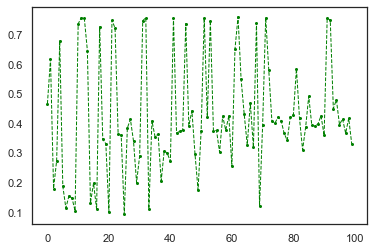

In [ ]:
plt.plot(test_accuracy, color = 'green', marker='o', linestyle='dashed', linewidth=1, markersize=2)

## 4. Evaluation

### 4.1 Recreate the optimized CNN model with the best hyperparameters

The optimized hyperparameters corresponding to the highest accuracy are taken into consideration to create the final model. This final model would be retrained and for the durther use.

In [ ]:
model = Sequential()   
model.add(
        Conv2D(
            filters=int(64*study.best_trial.params['n_filters']),
            kernel_size= (3,3),
            padding = 'same',
            activation= 'relu',
            input_shape=(32,32,3),
            )
        )  
n_cnn = study.best_trial.params['n_cnn']
if n_cnn > 0:
    num_filters1 = study.best_trial.params['n_filters_1']
    num_filters1 = int(num_filters1*70)
    model.add(
            Conv2D(
            filters=num_filters1,
            kernel_size= (3,3),
            padding = 'same',
            activation= 'relu'
            )
        )
    if n_cnn > 1:
        num_filters2 = study.best_trial.params['n_filters_2']
        num_filters2 = int(num_filters2*80)
        model.add(
                Conv2D(
                filters=num_filters2,
                kernel_size= (3,3),
                padding = 'same',
                activation= 'relu'
                )
            )
        if n_cnn > 2:
            num_filters3 = study.best_trial.params['n_filters_3']
            num_filters3 = int(num_filters3*80)
            model.add(
                    Conv2D(
                    filters=num_filters3,
                    kernel_size= (3,3),
                    padding = 'same',
                    activation= 'relu'
                    )
                )    
                    
model.add(MaxPooling2D(pool_size=(2,2)))   
model.add(Flatten())
    
n_layers = study.best_trial.params['n_layers']
    
if n_layers > 0:
    num_hidden1 = study.best_trial.params['n_units_1']
    num_hidden1 = int(num_hidden1*1500)
    model.add(Dense(num_hidden1, activation="relu"))
    dropout1 = study.best_trial.params['dropout_1']
    model.add(Dropout(rate=dropout1))
    if n_layers > 1:
        num_hidden2 = study.best_trial.params['n_units_2']
        num_hidden2 = int(num_hidden2*1200)
        model.add(Dense(num_hidden2, activation="relu"))
        dropout2 = study.best_trial.params['dropout_2']
        model.add(Dropout(rate=dropout2))
        if n_layers > 2:
            num_hidden3 = study.best_trial.params['n_units_3']
            num_hidden3 = int(num_hidden3*900)
            model.add(Dense(num_hidden3, activation="relu"))
            dropout3 = study.best_trial.params['dropout_3']
            model.add(Dropout(rate=dropout3))
    
model.add(Dense(10, activation="softmax"))

lr = study.best_trial.params['lr']   
    
opt = SGD(lr = lr)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 41)        1148      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 63)        23310     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 63)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16128)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 707)               11403203  
_________________________________________________________________
dropout_2 (Dropout)          (None, 707)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

In [ ]:
batch_size = study.best_trial.params['Batch_size']
datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1, # Randomly zoom image 
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images


datagen.fit(training_images)  

# Set a learning rate annealer

history = model.fit_generator(datagen.flow(training_images, training_labels, batch_size = batch_size),
                              epochs = 50, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch= training_images.shape[0] // batch_size,
                              callbacks=None)
    
# Evaluate the model accuracy on the test set.
score = model.evaluate(test_images, test_labels, verbose=0)
print ('Test loss: {}, Test accuracy: {}'.format(score[0], score[1]*100.0))


Epoch 1/50
 - 51s - loss: 1.9392 - accuracy: 0.3020 - val_loss: 1.6607 - val_accuracy: 0.4120
Epoch 2/50
 - 33s - loss: 1.6696 - accuracy: 0.4049 - val_loss: 1.4818 - val_accuracy: 0.4626
Epoch 3/50
 - 57s - loss: 1.5435 - accuracy: 0.4482 - val_loss: 1.3687 - val_accuracy: 0.5064
Epoch 4/50
 - 57s - loss: 1.4597 - accuracy: 0.4794 - val_loss: 1.2799 - val_accuracy: 0.5338
Epoch 5/50
 - 57s - loss: 1.3875 - accuracy: 0.5042 - val_loss: 1.2350 - val_accuracy: 0.5556
Epoch 6/50
 - 57s - loss: 1.3402 - accuracy: 0.5185 - val_loss: 1.1937 - val_accuracy: 0.5720
Epoch 7/50
 - 56s - loss: 1.2948 - accuracy: 0.5373 - val_loss: 1.1389 - val_accuracy: 0.5908
Epoch 8/50
 - 56s - loss: 1.2594 - accuracy: 0.5484 - val_loss: 1.1222 - val_accuracy: 0.5956
Epoch 9/50
 - 58s - loss: 1.2269 - accuracy: 0.5604 - val_loss: 1.0690 - val_accuracy: 0.6190
Epoch 10/50
 - 57s - loss: 1.1901 - accuracy: 0.5755 - val_loss: 1.0510 - val_accuracy: 0.6268
Epoch 11/50
 - 57s - loss: 1.1615 - accuracy: 0.5852 - val_

### 4.2 Training and validation curves

The code below is for plotting loss and accuracy curves for training and validation dataset. It shows you the training and validation curves obtained with 50 epochs.

The model reaches almost 76% test accuracy after 50 epochs.

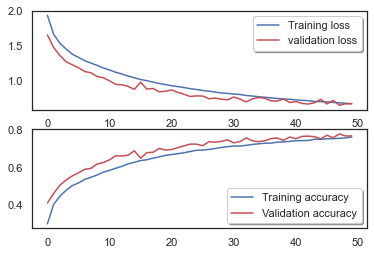

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### 4.3 Confusion matrix

Confusion matrix can be very helpfull to see the model drawbacks.

The confusion matrix is plotted for the test dataset.

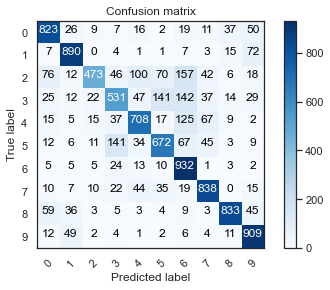

In [ ]:
# Look at confusion matrix 
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(test_images)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors

Y_true = test_labels
# compute the confusion matrix
confusion_mtx = confusion_matrix(test_labels, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

 

0:airplane   ,     1:automobile   ,    2:bird    ,   3:cat    ,   4:deer    ,   5:dog   ,    6:frog    ,   7:horse    ,   8:ship    ,   9:truck

Example: Here, it seems that our CNN has some troubles with identifying 5:'dog' with 3:'cat'.

### 4.4 Error Invesigation

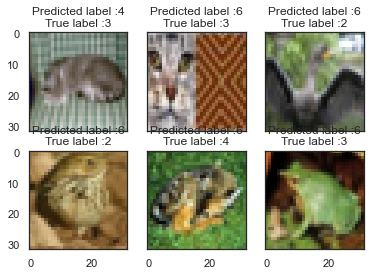

In [ ]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = test_images[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted picture
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)